# OFDM Signal Generation and Processing

This notebook demonstrates complete OFDM (Orthogonal Frequency Division Multiplexing) signal generation, transmission, and reception with channel estimation.

## 🎯 Key Features:
- **OFDM Symbol Generation** with pilot and data carriers
- **16-QAM Modulation** for data transmission
- **Channel Simulation** with multipath fading and noise
- **Channel Estimation** using pilot-based interpolation
- **Equalization and Demodulation** with BER calculation

## 📊 System Parameters:
- **Subcarriers**: 64 (K)
- **Cyclic Prefix**: 16 samples (25% of block)
- **Pilots**: 9 carriers for channel estimation
- **Modulation**: 16-QAM (4 bits/symbol)
- **Channel**: Multipath with AWGN

## 1. Import Libraries and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

# Set matplotlib parameters for better plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['grid.alpha'] = 0.3

print("📡 OFDM Signal Generation System")
print("=" * 40)

📡 OFDM Signal Generation System


## 2. OFDM System Parameters

In [2]:
# OFDM Parameters
K = 64  # number of OFDM subcarriers
CP = K//4  # length of the cyclic prefix: 25% of the block
P = 8  # number of pilot carriers per OFDM block
pilotValue = 3+3j  # The known value each pilot transmits

# Subcarrier allocation
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P]  # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carrier also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)

# Display system info
print(f"🔧 OFDM System Configuration:")
print(f"   Subcarriers (K): {K}")
print(f"   Cyclic Prefix: {CP} samples ({CP/K*100:.0f}%)")
print(f"   Pilot carriers: {len(pilotCarriers)} ({pilotCarriers})")
print(f"   Data carriers: {len(dataCarriers)}")
print(f"   Pilot value: {pilotValue}")

🔧 OFDM System Configuration:
   Subcarriers (K): 64
   Cyclic Prefix: 16 samples (25%)
   Pilot carriers: 9 ([ 0  8 16 24 32 40 48 56 63])
   Data carriers: 55
   Pilot value: (3+3j)


## 3. Visualize Subcarrier Allocation

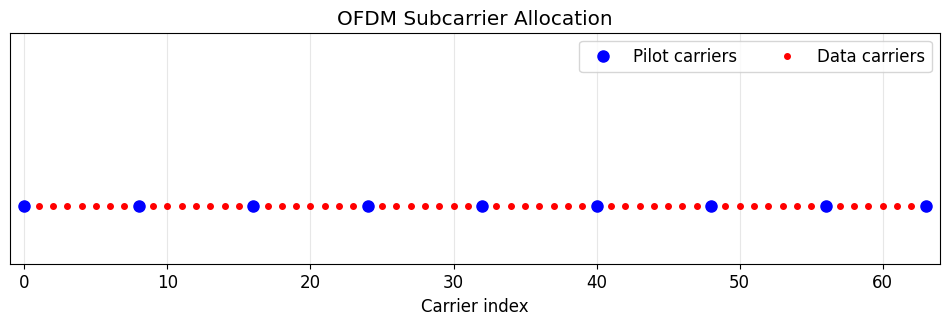

📊 Pilot carriers (blue): 9 carriers for channel estimation
📊 Data carriers (red): 55 carriers for payload transmission


In [3]:
plt.figure(figsize=(12, 3))
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', markersize=8, label='Pilot carriers')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', markersize=4, label='Data carriers')
plt.legend(fontsize=12, ncol=2)
plt.xlim((-1, K))
plt.ylim((-0.1, 0.3))
plt.xlabel('Carrier index')
plt.title('OFDM Subcarrier Allocation')
plt.yticks([])
plt.grid(True)
plt.show()

print(f"📊 Pilot carriers (blue): {len(pilotCarriers)} carriers for channel estimation")
print(f"📊 Data carriers (red): {len(dataCarriers)} carriers for payload transmission")

## 4. 16-QAM Modulation Setup

📶 16-QAM Modulation Configuration:
   Bits per symbol: 4
   Payload bits per OFDM symbol: 220
   Constellation points: 16


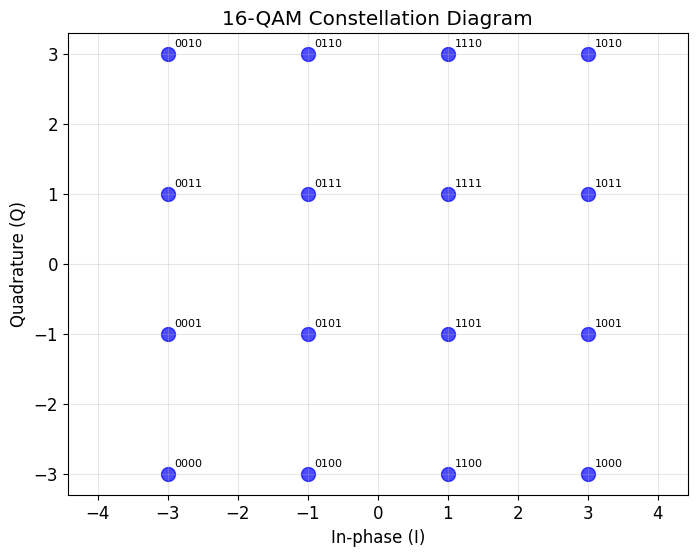

In [4]:
# 16-QAM Parameters
mu = 4  # bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = len(dataCarriers) * mu  # number of payload bits per OFDM symbol

# 16-QAM constellation mapping
mapping_table = {
    (0,0,0,0): -3-3j, (0,0,0,1): -3-1j, (0,0,1,0): -3+3j, (0,0,1,1): -3+1j,
    (0,1,0,0): -1-3j, (0,1,0,1): -1-1j, (0,1,1,0): -1+3j, (0,1,1,1): -1+1j,
    (1,0,0,0):  3-3j, (1,0,0,1):  3-1j, (1,0,1,0):  3+3j, (1,0,1,1):  3+1j,
    (1,1,0,0):  1-3j, (1,1,0,1):  1-1j, (1,1,1,0):  1+3j, (1,1,1,1):  1+1j
}
demapping_table = {v: k for k, v in mapping_table.items()}

print(f"📶 16-QAM Modulation Configuration:")
print(f"   Bits per symbol: {mu}")
print(f"   Payload bits per OFDM symbol: {payloadBits_per_OFDM}")
print(f"   Constellation points: {len(mapping_table)}")

# Visualize 16-QAM constellation
constellation_points = np.array(list(mapping_table.values()))
plt.figure(figsize=(8, 6))
plt.scatter(constellation_points.real, constellation_points.imag, s=100, c='blue', alpha=0.7)
plt.grid(True, alpha=0.3)
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.title('16-QAM Constellation Diagram')
plt.axis('equal')

# Add bit labels to constellation points
for bits, point in mapping_table.items():
    bit_str = ''.join(map(str, bits))
    plt.annotate(bit_str, (point.real, point.imag), xytext=(5, 5), 
                textcoords='offset points', fontsize=8)

plt.show()

## 5. Channel Model Setup

📡 Channel Configuration:
   Channel impulse response: [1. +0.j  0. +0.j  0.3+0.3j]
   SNR: 25 dB
   Channel taps: 3


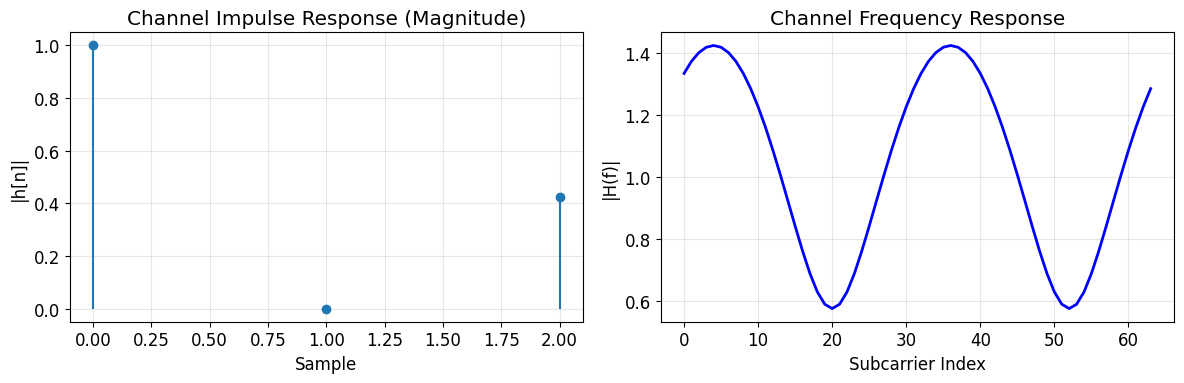

In [5]:
# Channel parameters
channelResponse = np.array([1, 0, 0.3+0.3j])  # multipath channel impulse response
H_exact = np.fft.fft(channelResponse, K)  # exact channel frequency response
SNRdb = 25  # signal to noise-ratio in dB at the receiver

print(f"📡 Channel Configuration:")
print(f"   Channel impulse response: {channelResponse}")
print(f"   SNR: {SNRdb} dB")
print(f"   Channel taps: {len(channelResponse)}")

# Visualize channel frequency response
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.stem(np.arange(len(channelResponse)), abs(channelResponse), basefmt=" ")
plt.title('Channel Impulse Response (Magnitude)')
plt.xlabel('Sample')
plt.ylabel('|h[n]|')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(allCarriers, abs(H_exact), 'b-', linewidth=2)
plt.title('Channel Frequency Response')
plt.xlabel('Subcarrier Index')
plt.ylabel('|H(f)|')
plt.grid(True)

plt.tight_layout()
plt.show()

## 6. OFDM Processing Functions

In [6]:
def SP(bits):
    """Serial to Parallel: Convert bit stream to groups for QAM mapping"""
    return bits.reshape((len(dataCarriers), mu))

def Mapping(bits):
    """Map bit groups to 16-QAM constellation points"""
    return np.array([mapping_table[tuple(b)] for b in bits])

def OFDM_symbol(QAM_payload):
    """Create OFDM symbol by allocating pilots and data"""
    symbol = np.zeros(K, dtype=complex)
    symbol[pilotCarriers] = pilotValue  # allocate pilot subcarriers
    symbol[dataCarriers] = QAM_payload  # allocate data subcarriers
    return symbol

def IDFT(OFDM_data):
    """Inverse DFT to convert frequency domain to time domain"""
    return np.fft.ifft(OFDM_data)

def addCP(OFDM_time):
    """Add cyclic prefix to OFDM symbol"""
    cp = OFDM_time[-CP:]  # take the last CP samples
    return np.hstack([cp, OFDM_time])  # add them to the beginning

def channel(signal):
    """Simulate multipath channel with AWGN"""
    # Convolve with channel impulse response
    convolved = np.convolve(signal, channelResponse)
    
    # Calculate noise power based on SNR
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)
    
    # Generate complex AWGN
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape) + 
                                1j*np.random.randn(*convolved.shape))
    return convolved + noise, sigma2

def removeCP(signal):
    """Remove cyclic prefix from received signal"""
    return signal[CP:(CP+K)]

def DFT(OFDM_RX):
    """DFT to convert time domain back to frequency domain"""
    return np.fft.fft(OFDM_RX)

def channelEstimate(OFDM_demod):
    """Estimate channel using pilot carriers and interpolation"""
    pilots = OFDM_demod[pilotCarriers]  # extract pilot values
    Hest_at_pilots = pilots / pilotValue  # estimate channel at pilots
    
    # Interpolate channel estimates to all carriers
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), 
                                         kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), 
                                           kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    return Hest, Hest_at_pilots

def equalize(OFDM_demod, Hest):
    """Equalize received signal using channel estimate"""
    return OFDM_demod / Hest

def get_payload(equalized):
    """Extract data carriers from equalized signal"""
    return equalized[dataCarriers]

def Demapping(QAM):
    """Demap QAM symbols back to bits using hard decision"""
    constellation = np.array([x for x in demapping_table.keys()])
    
    # Find nearest constellation point for each received symbol
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    const_index = dists.argmin(axis=1)
    hardDecision = constellation[const_index]
    
    # Convert back to bits
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

def PS(bits):
    """Parallel to Serial: Convert bit groups back to stream"""
    return bits.reshape((-1,))

print("✅ OFDM processing functions defined successfully!")

✅ OFDM processing functions defined successfully!


## 7. Generate and Process OFDM Signal

In [7]:
# Generate multiple OFDM samples for dataset creation
num_samples = 1000  # Number of OFDM symbols to generate

print(f"🎲 Generating {num_samples} OFDM samples for dataset...")

# Initialize storage for all samples
all_tx_signals = []
all_rx_signals = []
all_bits = []
all_qam_symbols = []

print("📡 OFDM Sample Generation Progress:")
print("=" * 60)

for sample_idx in range(num_samples):
    # Generate random payload bits for this sample
    bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM,))
    
    # OFDM Transmitter Chain
    bits_SP = SP(bits)
    QAM = Mapping(bits_SP)
    OFDM_data = OFDM_symbol(QAM)
    OFDM_time = IDFT(OFDM_data)
    OFDM_withCP = addCP(OFDM_time)
    OFDM_TX = OFDM_withCP
    
    # Channel Transmission
    OFDM_RX, noise_var = channel(OFDM_TX)
    
    # Store the signals (match lengths)
    rx_matched = OFDM_RX[:len(OFDM_TX)]  # Match TX length
    all_tx_signals.append(OFDM_TX)
    all_rx_signals.append(rx_matched)
    all_bits.append(bits)
    all_qam_symbols.append(QAM)
    
    # Store noise variance for first sample to display later
    if sample_idx == 0:
        first_noise_variance = noise_var
    
    # Progress indicator
    if (sample_idx + 1) % 100 == 0 or (sample_idx + 1) == num_samples:
        progress = (sample_idx + 1) / num_samples * 100
        print(f"   Sample [{sample_idx+1:4d}/{num_samples}] "
              f"Progress: {progress:5.1f}% "
              f"{'█' * int(progress // 5)}")

print(f"\n✅ Generated {num_samples} OFDM samples successfully!")
print(f"   📊 Each TX signal: {len(all_tx_signals[0])} samples")
print(f"   📊 Each RX signal: {len(all_rx_signals[0])} samples")
print(f"   📊 Each bit sequence: {len(all_bits[0])} bits")
print(f"   📊 Each QAM sequence: {len(all_qam_symbols[0])} symbols")
print(f"   🔊 Noise variance (σ²): {first_noise_variance:.6f}")
print(f"   🔊 Noise std deviation (σ): {np.sqrt(first_noise_variance):.6f}")

# For compatibility with rest of notebook, keep last sample as current signals
OFDM_TX = all_tx_signals[-1]
OFDM_RX = all_rx_signals[-1]
bits = all_bits[-1]
QAM = all_qam_symbols[-1]

🎲 Generating 1000 OFDM samples for dataset...
📡 OFDM Sample Generation Progress:
   Sample [ 100/1000] Progress:  10.0% ██
   Sample [ 200/1000] Progress:  20.0% ████
   Sample [ 300/1000] Progress:  30.0% ██████
   Sample [ 400/1000] Progress:  40.0% ████████
   Sample [ 500/1000] Progress:  50.0% ██████████
   Sample [ 600/1000] Progress:  60.0% ████████████
   Sample [ 700/1000] Progress:  70.0% ██████████████
   Sample [ 800/1000] Progress:  80.0% ████████████████
   Sample [ 900/1000] Progress:  90.0% ██████████████████
   Sample [1000/1000] Progress: 100.0% ████████████████████

✅ Generated 1000 OFDM samples successfully!
   📊 Each TX signal: 80 samples
   📊 Each RX signal: 80 samples
   📊 Each bit sequence: 220 bits
   📊 Each QAM sequence: 55 symbols
   🔊 Noise variance (σ²): 0.000663
   🔊 Noise std deviation (σ): 0.025749


In [8]:
# Process the last sample for detailed analysis (traditional OFDM processing)
print("\n📡 Processing Last Sample for Detailed Analysis:")
print("   1. Remove Cyclic Prefix")
OFDM_RX_noCP = removeCP(OFDM_RX)

print("   2. FFT (Time → Frequency Domain)")
OFDM_demod = DFT(OFDM_RX_noCP)

print("   3. Channel Estimation")
Hest, Hest_at_pilots = channelEstimate(OFDM_demod)

print("   4. Channel Equalization")
equalized_Hest = equalize(OFDM_demod, Hest)

print("   5. Extract Data Payload")
QAM_est = get_payload(equalized_Hest)

print("   6. 16-QAM Demapping")
PS_est, hardDecision = Demapping(QAM_est)

print("   7. Parallel to Serial")
bits_est = PS(PS_est)

print(f"✅ Last sample processed: {len(bits_est)} bits recovered")
print(f"📊 Dataset ready: {num_samples} samples with TX/RX signal pairs")


📡 Processing Last Sample for Detailed Analysis:
   1. Remove Cyclic Prefix
   2. FFT (Time → Frequency Domain)
   3. Channel Estimation
   4. Channel Equalization
   5. Extract Data Payload
   6. 16-QAM Demapping
   7. Parallel to Serial
✅ Last sample processed: 220 bits recovered
📊 Dataset ready: 1000 samples with TX/RX signal pairs



📈 Dataset Visualization and Analysis:


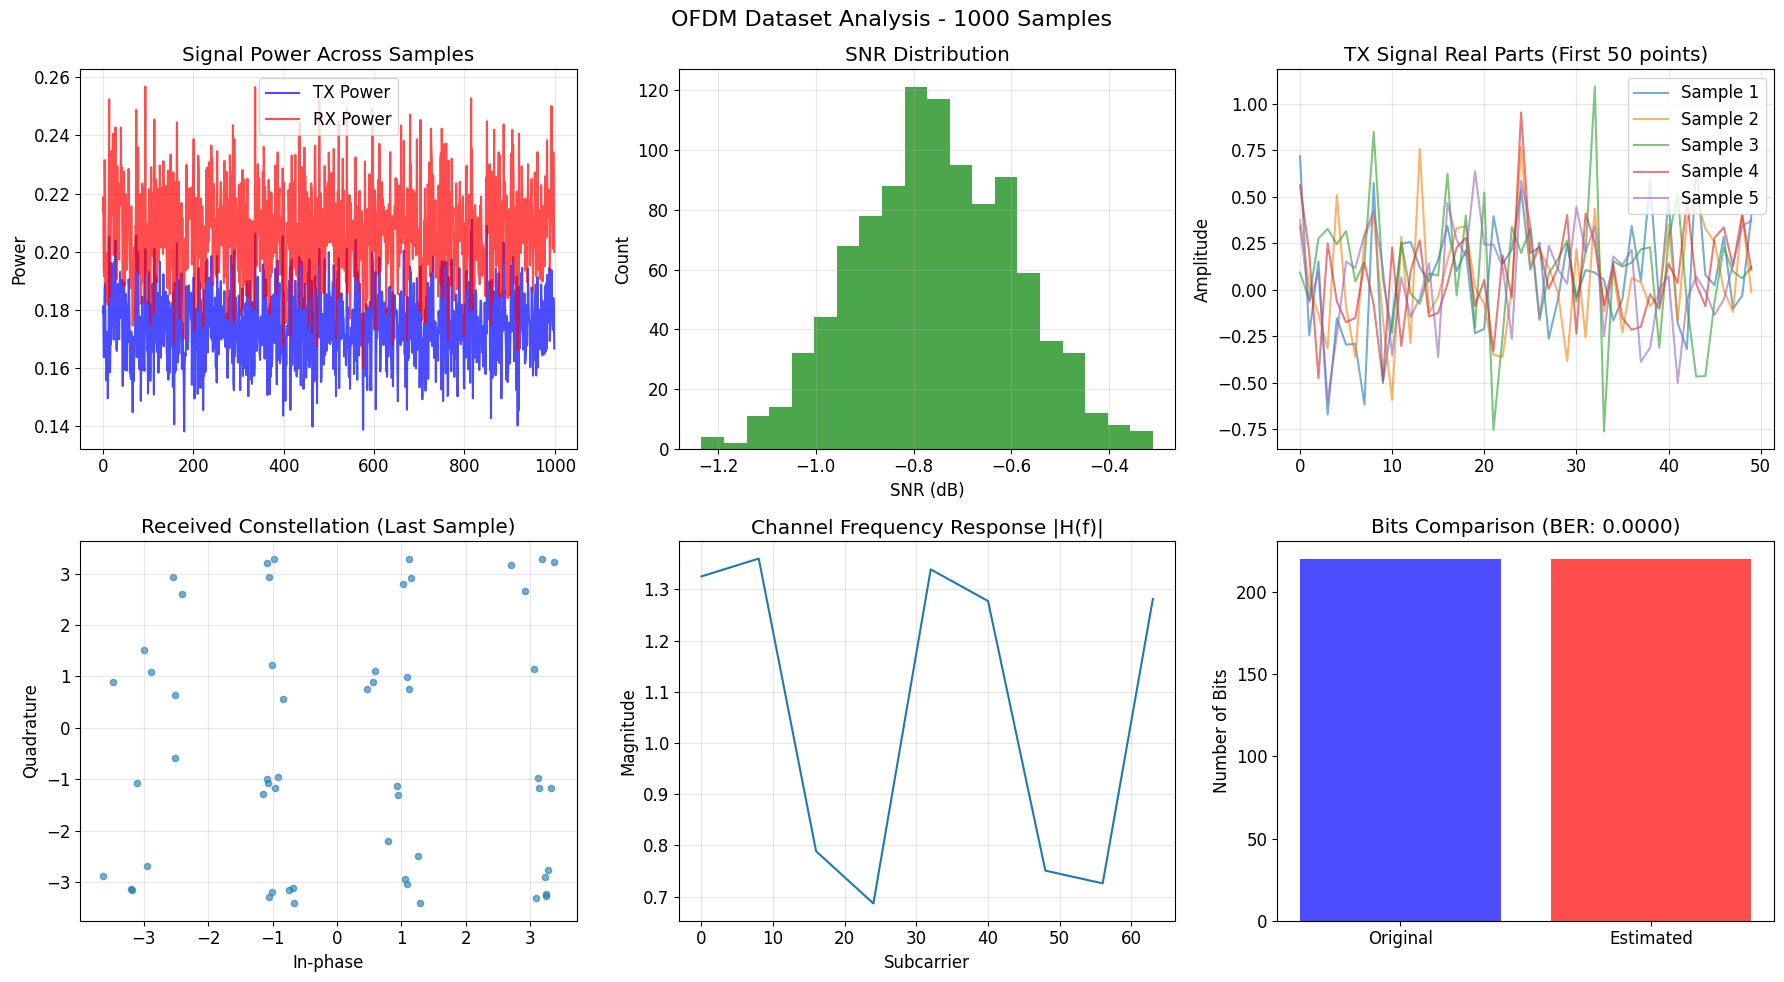

📊 Dataset Statistics:
   • Total Samples: 1000
   • TX Signal Length: 80 samples each
   • RX Signal Length: 80 samples each
   • Average TX Power: 0.1739
   • Average RX Power: 0.2071
   • SNR Range: -1.23 to -0.31 dB
   • Last Sample BER: 0.0000
✅ Dataset generation and analysis complete!


In [9]:
# Visualize multiple samples overview
print("\n📈 Dataset Visualization and Analysis:")

# Plot signal statistics across all samples
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'OFDM Dataset Analysis - {num_samples} Samples', fontsize=16)

# Signal power statistics
tx_powers = [np.mean(np.abs(tx_sig)**2) for tx_sig in all_tx_signals]
rx_powers = [np.mean(np.abs(rx_sig)**2) for rx_sig in all_rx_signals]
snr_values = [10*np.log10(tx_p/rx_p) if rx_p > 0 else 0 for tx_p, rx_p in zip(tx_powers, rx_powers)]

axes[0, 0].plot(tx_powers, 'b-', alpha=0.7, label='TX Power')
axes[0, 0].plot(rx_powers, 'r-', alpha=0.7, label='RX Power')
axes[0, 0].set_title('Signal Power Across Samples')
axes[0, 0].set_ylabel('Power')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# SNR distribution
axes[0, 1].hist(snr_values, bins=20, alpha=0.7, color='green')
axes[0, 1].set_title('SNR Distribution')
axes[0, 1].set_xlabel('SNR (dB)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(True, alpha=0.3)

# First 5 samples TX signals
for i in range(min(5, num_samples)):
    axes[0, 2].plot(np.real(all_tx_signals[i][:50]), alpha=0.6, label=f'Sample {i+1}')
axes[0, 2].set_title('TX Signal Real Parts (First 50 points)')
axes[0, 2].set_ylabel('Amplitude')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Signal constellation for last sample
axes[1, 0].scatter(np.real(QAM_est), np.imag(QAM_est), alpha=0.6, s=20)
axes[1, 0].set_title('Received Constellation (Last Sample)')
axes[1, 0].set_xlabel('In-phase')
axes[1, 0].set_ylabel('Quadrature')
axes[1, 0].grid(True, alpha=0.3)

# Channel frequency response for last sample
axes[1, 1].plot(np.abs(Hest))
axes[1, 1].set_title('Channel Frequency Response |H(f)|')
axes[1, 1].set_xlabel('Subcarrier')
axes[1, 1].set_ylabel('Magnitude')
axes[1, 1].grid(True, alpha=0.3)

# Bit Error Rate estimation for last sample
ber = np.sum(bits != bits_est) / len(bits)
axes[1, 2].bar(['Original', 'Estimated'], [len(bits), len(bits_est)], 
              color=['blue', 'red'], alpha=0.7)
axes[1, 2].set_title(f'Bits Comparison (BER: {ber:.4f})')
axes[1, 2].set_ylabel('Number of Bits')

plt.tight_layout()
plt.show()

print(f"📊 Dataset Statistics:")
print(f"   • Total Samples: {num_samples}")
print(f"   • TX Signal Length: {len(all_tx_signals[0])} samples each")
print(f"   • RX Signal Length: {len(all_rx_signals[0])} samples each")
print(f"   • Average TX Power: {np.mean(tx_powers):.4f}")
print(f"   • Average RX Power: {np.mean(rx_powers):.4f}")
print(f"   • SNR Range: {np.min(snr_values):.2f} to {np.max(snr_values):.2f} dB")
print(f"   • Last Sample BER: {ber:.4f}")
print(f"✅ Dataset generation and analysis complete!")

## 8. Channel Transmission and Reception

In [10]:
# Transmit through channel
print("🌊 Channel Transmission:")
print(f"   Applying multipath channel (taps: {len(channelResponse)})")
print(f"   Adding AWGN noise (SNR: {SNRdb} dB)")
OFDM_RX, noise_variance = channel(OFDM_TX)
print(f"   🔊 Noise variance (σ²): {noise_variance:.6f}")
print(f"   🔊 Noise std deviation (σ): {np.sqrt(noise_variance):.6f}")

# OFDM Receiver Chain
print("\n📡 OFDM Receiver Processing:")
print("   1. Remove Cyclic Prefix")
OFDM_RX_noCP = removeCP(OFDM_RX)

print("   2. FFT (Time → Frequency Domain)")
OFDM_demod = DFT(OFDM_RX_noCP)

print("   3. Channel Estimation")
Hest, Hest_at_pilots = channelEstimate(OFDM_demod)

print("   4. Channel Equalization")
equalized_Hest = equalize(OFDM_demod, Hest)

print("   5. Extract Data Payload")
QAM_est = get_payload(equalized_Hest)

print("   6. 16-QAM Demapping")
PS_est, hardDecision = Demapping(QAM_est)

print("   7. Parallel to Serial")
bits_est = PS(PS_est)

print(f"✅ Received signal processed: {len(bits_est)} bits recovered")

🌊 Channel Transmission:
   Applying multipath channel (taps: 3)
   Adding AWGN noise (SNR: 25 dB)
   🔊 Noise variance (σ²): 0.000618
   🔊 Noise std deviation (σ): 0.024863

📡 OFDM Receiver Processing:
   1. Remove Cyclic Prefix
   2. FFT (Time → Frequency Domain)
   3. Channel Estimation
   4. Channel Equalization
   5. Extract Data Payload
   6. 16-QAM Demapping
   7. Parallel to Serial
✅ Received signal processed: 220 bits recovered


## 8.1. Save Signal Data to CSV Files

In [11]:
import pandas as pd
import os
from datetime import datetime

# Create data directory if it doesn't exist
data_dir = "ofdm_signal_data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"📁 Created directory: {data_dir}")

# Generate timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print(f"💾 Saving {num_samples} OFDM samples to CSV file...")

# Prepare dataset with only essential columns
combined_data = []

for sample_idx in range(num_samples):
    tx_signal = all_tx_signals[sample_idx]
    rx_signal = all_rx_signals[sample_idx]
    
    # Create sample-level data with only essential columns
    for i in range(len(tx_signal)):
        combined_data.append({
            'sample_id': sample_idx,
            'time_index': i,
            'tx_real': tx_signal[i].real,
            'tx_imag': tx_signal[i].imag,
            'rx_real': rx_signal[i].real,
            'rx_imag': rx_signal[i].imag
        })

# Create DataFrame
combined_df = pd.DataFrame(combined_data)

# Save to single CSV file
combined_filename = f"{data_dir}/ofdm_signals_{num_samples}samples_{timestamp}.csv"
combined_df.to_csv(combined_filename, index=True)

print(f"\n💾 Dataset Saved Successfully:")
print(f"   📊 OFDM Signals: {combined_filename}")
print(f"      - Total data points: {len(combined_df):,}")
print(f"      - Samples: {num_samples}")
print(f"      - Time points per sample: {len(all_tx_signals[0])}")
print(f"      - Columns: {list(combined_df.columns)}")
print(f"      - File size: {os.path.getsize(combined_filename) / 1024 / 1024:.1f} MB")

# Display sample of the data
print(f"\n📊 Dataset Sample (first 5 rows):")
print(combined_df.head())

print(f"\n📊 Dataset Statistics:")
print(f"   Sample IDs: {combined_df['sample_id'].min()} to {combined_df['sample_id'].max()}")
print(f"   Time indices: {combined_df['time_index'].min()} to {combined_df['time_index'].max()}")
print(f"   TX real range: [{combined_df['tx_real'].min():.4f}, {combined_df['tx_real'].max():.4f}]")
print(f"   RX real range: [{combined_df['rx_real'].min():.4f}, {combined_df['rx_real'].max():.4f}]")

print(f"\n✅ Dataset generation complete!")
print(f"   📁 Single file saved with essential columns only")
print(f"   🎯 Ready for machine learning training")

💾 Saving 1000 OFDM samples to CSV file...

💾 Dataset Saved Successfully:
   📊 OFDM Signals: ofdm_signal_data/ofdm_signals_1000samples_20251215_210922.csv
      - Total data points: 80,000
      - Samples: 1000
      - Time points per sample: 80
      - Columns: ['sample_id', 'time_index', 'tx_real', 'tx_imag', 'rx_real', 'rx_imag']
      - File size: 7.1 MB

📊 Dataset Sample (first 5 rows):
   sample_id  time_index   tx_real   tx_imag   rx_real   rx_imag
0          0           0  0.718750  0.500000  0.735720  0.483118
1          0           1 -0.242509 -0.005055 -0.204632 -0.025540
2          0           2  0.153626  0.126078  0.272017  0.464126
3          0           3 -0.669507  0.384641 -0.735886  0.320749
4          0           4 -0.151911  0.253152 -0.153785  0.364124

📊 Dataset Statistics:
   Sample IDs: 0 to 999
   Time indices: 0 to 79
   TX real range: [-1.1217, 1.2812]
   RX real range: [-1.2963, 1.3760]

✅ Dataset generation complete!
   📁 Single file saved with essential co

## 9. Visualization: Time Domain Signals

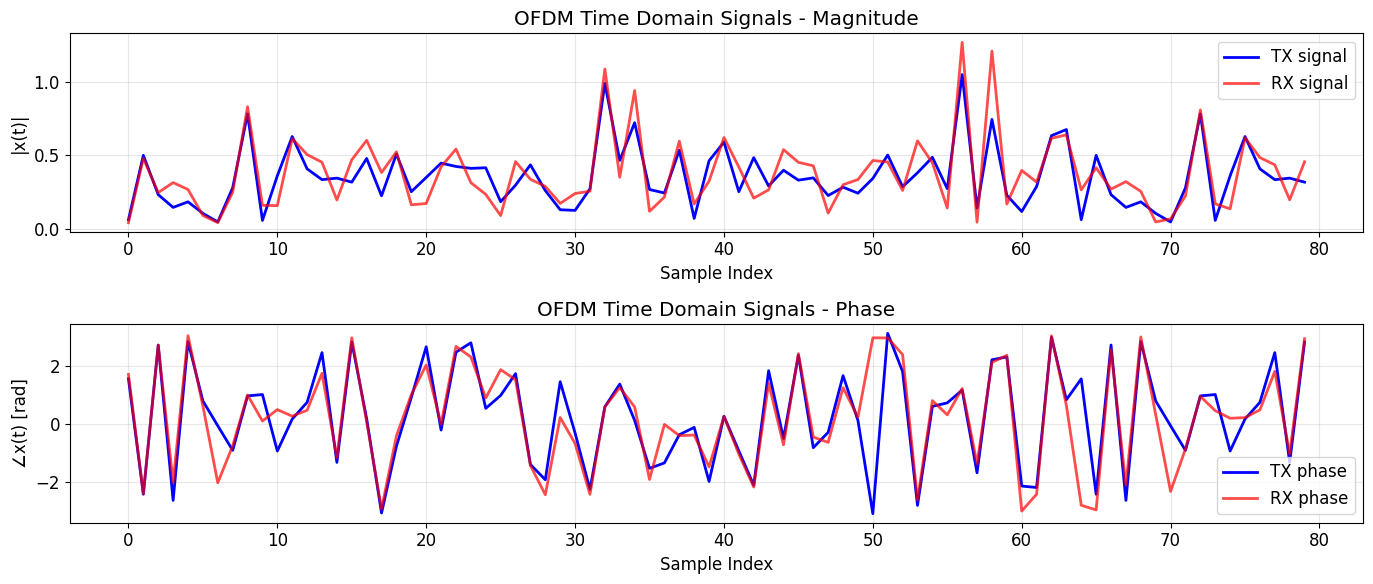

📊 Signal Analysis:
   TX signal power: 0.1667
   RX signal power: 0.2024
   Signal length: TX=80, RX=82


In [12]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(abs(OFDM_TX), 'b-', linewidth=2, label='TX signal')
plt.plot(abs(OFDM_RX[:len(OFDM_TX)]), 'r-', alpha=0.7, linewidth=2, label='RX signal')
plt.legend(fontsize=12)
plt.title('OFDM Time Domain Signals - Magnitude')
plt.xlabel('Sample Index')
plt.ylabel('|x(t)|')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.angle(OFDM_TX), 'b-', linewidth=2, label='TX phase')
plt.plot(np.angle(OFDM_RX[:len(OFDM_TX)]), 'r-', alpha=0.7, linewidth=2, label='RX phase')
plt.legend(fontsize=12)
plt.title('OFDM Time Domain Signals - Phase')
plt.xlabel('Sample Index')
plt.ylabel('∠x(t) [rad]')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"📊 Signal Analysis:")
print(f"   TX signal power: {np.mean(abs(OFDM_TX)**2):.4f}")
print(f"   RX signal power: {np.mean(abs(OFDM_RX[:len(OFDM_TX)])**2):.4f}")
print(f"   Signal length: TX={len(OFDM_TX)}, RX={len(OFDM_RX)}")

## 10. Visualization: Channel Estimation

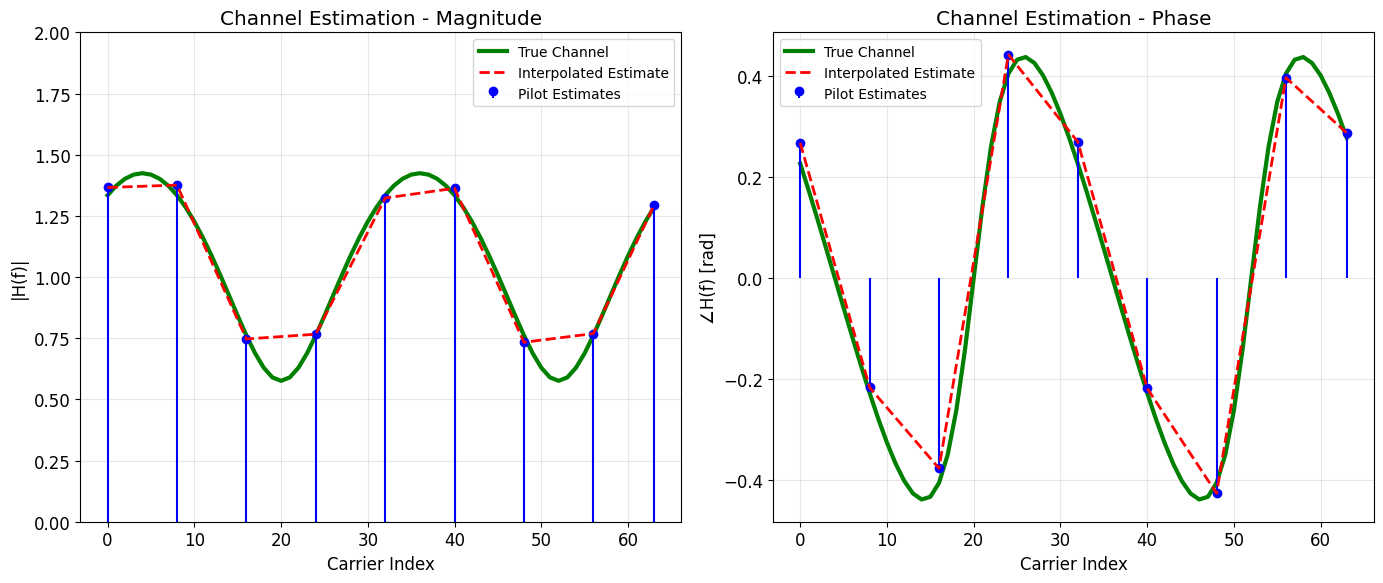

📈 Channel Estimation Performance:
   MSE between true and estimated channel: 0.007373
   Number of pilot carriers used: 9


In [13]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(allCarriers, abs(H_exact), 'g-', linewidth=3, label='True Channel')
plt.stem(pilotCarriers, abs(Hest_at_pilots), basefmt=" ", linefmt='b-', 
         markerfmt='bo', label='Pilot Estimates')
plt.plot(allCarriers, abs(Hest), 'r--', linewidth=2, label='Interpolated Estimate')
plt.grid(True)
plt.xlabel('Carrier Index')
plt.ylabel('|H(f)|')
plt.title('Channel Estimation - Magnitude')
plt.legend(fontsize=10)
plt.ylim(0, 2)

plt.subplot(1, 2, 2)
plt.plot(allCarriers, np.angle(H_exact), 'g-', linewidth=3, label='True Channel')
plt.stem(pilotCarriers, np.angle(Hest_at_pilots), basefmt=" ", linefmt='b-', 
         markerfmt='bo', label='Pilot Estimates')
plt.plot(allCarriers, np.angle(Hest), 'r--', linewidth=2, label='Interpolated Estimate')
plt.grid(True)
plt.xlabel('Carrier Index')
plt.ylabel('∠H(f) [rad]')
plt.title('Channel Estimation - Phase')
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Calculate estimation error
channel_error = np.mean(abs(H_exact - Hest)**2)
print(f"📈 Channel Estimation Performance:")
print(f"   MSE between true and estimated channel: {channel_error:.6f}")
print(f"   Number of pilot carriers used: {len(pilotCarriers)}")

## 11. Visualization: Constellation Diagrams

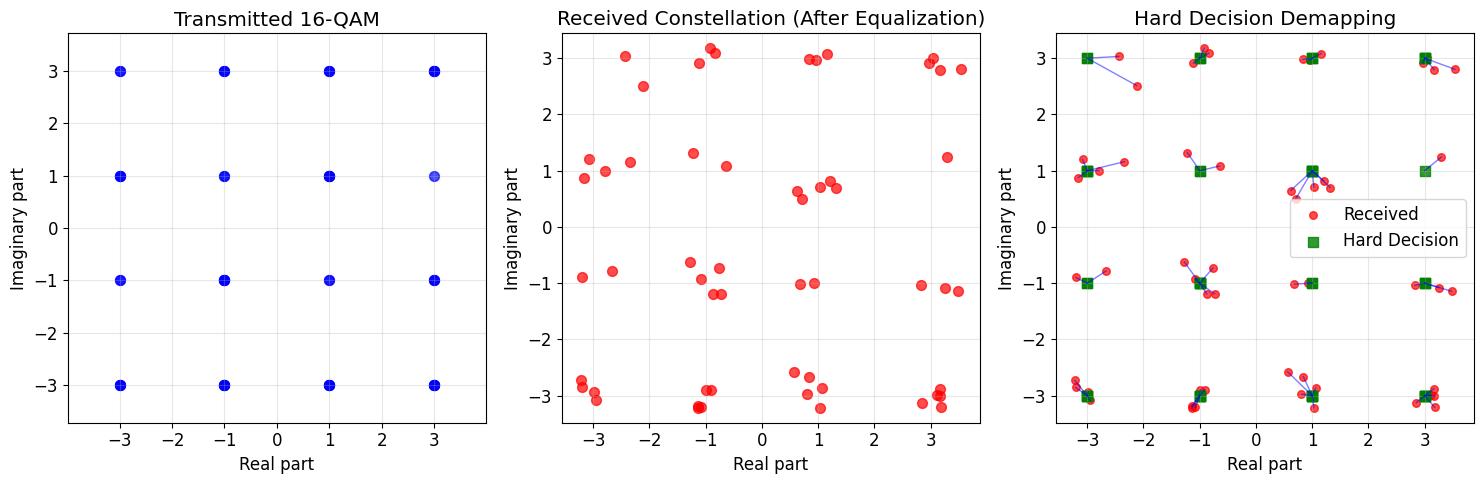

📊 Symbol Error Analysis:
   Total symbols: 55
   Symbol errors: 0
   Symbol Error Rate (SER): 0.0000


In [14]:
plt.figure(figsize=(15, 5))

# Original constellation
plt.subplot(1, 3, 1)
plt.scatter(QAM.real, QAM.imag, alpha=0.7, s=50, c='blue')
plt.grid(True)
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Transmitted 16-QAM')
plt.axis('equal')

# Received constellation
plt.subplot(1, 3, 2)
plt.scatter(QAM_est.real, QAM_est.imag, alpha=0.7, s=50, c='red')
plt.grid(True)
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Received Constellation (After Equalization)')
plt.axis('equal')

# Hard decision demapping
plt.subplot(1, 3, 3)
# Show the mapping from received to hard decision
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-', alpha=0.5, linewidth=1)
plt.scatter(QAM_est.real, QAM_est.imag, alpha=0.7, s=30, c='red', label='Received')
plt.scatter(hardDecision.real, hardDecision.imag, alpha=0.8, s=50, c='green', 
           marker='s', label='Hard Decision')
plt.grid(True)
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Hard Decision Demapping')
plt.legend()
plt.axis('equal')

plt.tight_layout()
plt.show()

# Symbol error analysis
symbol_errors = np.sum(QAM != hardDecision)
symbol_error_rate = symbol_errors / len(QAM)
print(f"📊 Symbol Error Analysis:")
print(f"   Total symbols: {len(QAM)}")
print(f"   Symbol errors: {symbol_errors}")
print(f"   Symbol Error Rate (SER): {symbol_error_rate:.4f}")

## 12. Bit Error Rate Calculation

In [15]:
# Calculate Bit Error Rate
bit_errors = np.sum(abs(bits - bits_est))
ber = bit_errors / len(bits)

print(f"🎯 OFDM System Performance Results:")
print("=" * 50)
print(f"📡 System Parameters:")
print(f"   Subcarriers: {K}")
print(f"   SNR: {SNRdb} dB")
print(f"   Modulation: 16-QAM")
print(f"   Channel: Multipath + AWGN")
print(f"\n📊 Performance Metrics:")
print(f"   Total bits transmitted: {len(bits)}")
print(f"   Bit errors: {bit_errors}")
print(f"   Bit Error Rate (BER): {ber:.6f}")
print(f"   Symbol Error Rate (SER): {symbol_error_rate:.6f}")
print(f"   Channel estimation MSE: {channel_error:.6f}")
print(f"\n🎉 OFDM transmission {'SUCCESS' if ber < 0.01 else 'COMPLETED'}!")

# Visualize bit comparison
if len(bits) <= 100:  # Only show if reasonable number of bits
    plt.figure(figsize=(12, 4))
    
    bit_indices = np.arange(len(bits))
    error_indices = bit_indices[bits != bits_est]
    
    plt.subplot(2, 1, 1)
    plt.stem(bit_indices, bits, basefmt=" ", linefmt='b-', markerfmt='bo', 
             label='Transmitted bits')
    plt.title('Transmitted Bits')
    plt.ylabel('Bit Value')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.stem(bit_indices, bits_est, basefmt=" ", linefmt='g-', markerfmt='go', 
             label='Received bits')
    if len(error_indices) > 0:
        plt.stem(error_indices, bits_est[error_indices], basefmt=" ", 
                linefmt='r-', markerfmt='ro', label='Bit errors')
    plt.title('Received Bits (Errors in Red)')
    plt.xlabel('Bit Index')
    plt.ylabel('Bit Value')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"\n(Bit visualization skipped - too many bits: {len(bits)})")

🎯 OFDM System Performance Results:
📡 System Parameters:
   Subcarriers: 64
   SNR: 25 dB
   Modulation: 16-QAM
   Channel: Multipath + AWGN

📊 Performance Metrics:
   Total bits transmitted: 220
   Bit errors: 0
   Bit Error Rate (BER): 0.000000
   Symbol Error Rate (SER): 0.000000
   Channel estimation MSE: 0.007373

🎉 OFDM transmission SUCCESS!

(Bit visualization skipped - too many bits: 220)


## 13. System Summary and Analysis

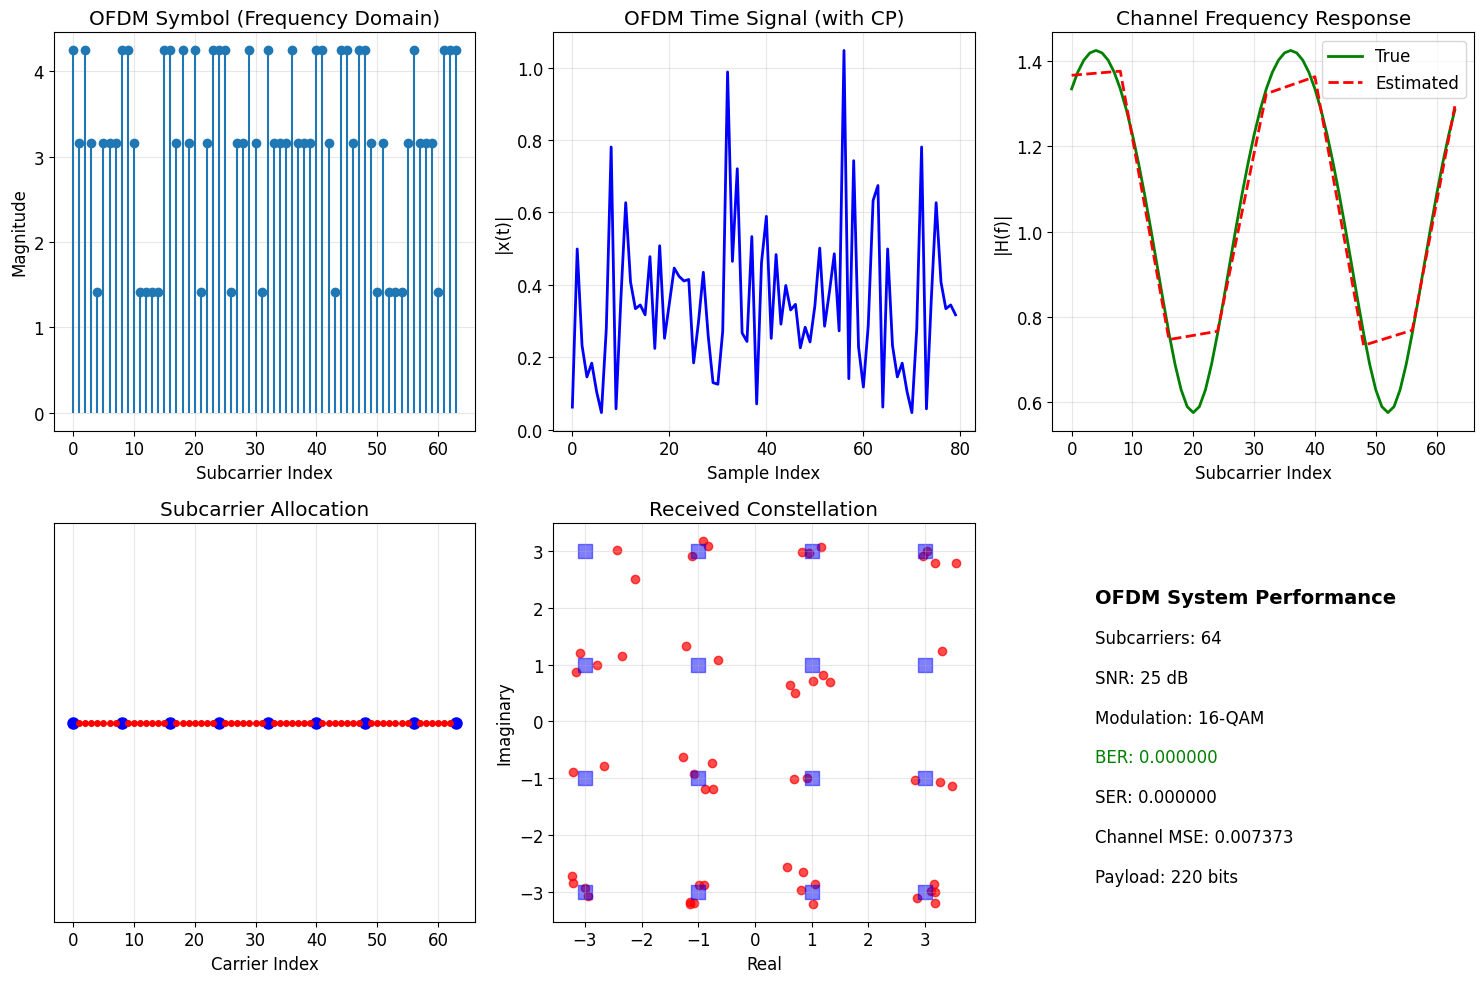


✅ OFDM Signal Generation and Processing Complete!
📋 Summary: Generated and processed OFDM signals with 64 subcarriers,
    achieving BER = 0.000000 at SNR = 25 dB using 16-QAM modulation


In [16]:
# Create a comprehensive system summary
plt.figure(figsize=(15, 10))

# Plot 1: Frequency domain view
plt.subplot(2, 3, 1)
plt.stem(allCarriers, abs(OFDM_data), basefmt=" ")
plt.title('OFDM Symbol (Frequency Domain)')
plt.xlabel('Subcarrier Index')
plt.ylabel('Magnitude')
plt.grid(True)

# Plot 2: Time domain signal
plt.subplot(2, 3, 2)
plt.plot(abs(OFDM_TX), 'b-', linewidth=2)
plt.title('OFDM Time Signal (with CP)')
plt.xlabel('Sample Index')
plt.ylabel('|x(t)|')
plt.grid(True)

# Plot 3: Channel frequency response
plt.subplot(2, 3, 3)
plt.plot(allCarriers, abs(H_exact), 'g-', linewidth=2, label='True')
plt.plot(allCarriers, abs(Hest), 'r--', linewidth=2, label='Estimated')
plt.title('Channel Frequency Response')
plt.xlabel('Subcarrier Index')
plt.ylabel('|H(f)|')
plt.legend()
plt.grid(True)

# Plot 4: Pilot allocation
plt.subplot(2, 3, 4)
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', markersize=8)
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', markersize=4)
plt.title('Subcarrier Allocation')
plt.xlabel('Carrier Index')
plt.yticks([])
plt.grid(True)

# Plot 5: Constellation
plt.subplot(2, 3, 5)
plt.scatter(QAM_est.real, QAM_est.imag, alpha=0.7, c='red')
plt.scatter(constellation_points.real, constellation_points.imag, 
           s=100, c='blue', marker='s', alpha=0.5)
plt.title('Received Constellation')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid(True)
plt.axis('equal')

# Plot 6: Performance summary (text)
plt.subplot(2, 3, 6)
plt.text(0.1, 0.8, f'OFDM System Performance', fontsize=14, fontweight='bold')
plt.text(0.1, 0.7, f'Subcarriers: {K}', fontsize=12)
plt.text(0.1, 0.6, f'SNR: {SNRdb} dB', fontsize=12)
plt.text(0.1, 0.5, f'Modulation: 16-QAM', fontsize=12)
plt.text(0.1, 0.4, f'BER: {ber:.6f}', fontsize=12, 
         color='green' if ber < 0.01 else 'red')
plt.text(0.1, 0.3, f'SER: {symbol_error_rate:.6f}', fontsize=12)
plt.text(0.1, 0.2, f'Channel MSE: {channel_error:.6f}', fontsize=12)
plt.text(0.1, 0.1, f'Payload: {payloadBits_per_OFDM} bits', fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n✅ OFDM Signal Generation and Processing Complete!")
print(f"📋 Summary: Generated and processed OFDM signals with {K} subcarriers,")
print(f"    achieving BER = {ber:.6f} at SNR = {SNRdb} dB using 16-QAM modulation")